In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from scipy.sparse import hstack
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.stem import WordNetLemmatizer



Number of Samples: 10189
Number of Unique Labels: 8
Missing Values:
 Question    0
label       0
dtype: int64

Sample Entries:
                                             Question  label
0  A solitaire game is played as follows.  Six di...      3
1  2. The school table tennis championship was he...      5
2  Given that $x, y,$ and $z$ are real numbers th...      0
3  $25 \cdot 22$ Given three distinct points $P\l...      1
4  I am thinking of a five-digit number composed ...      5


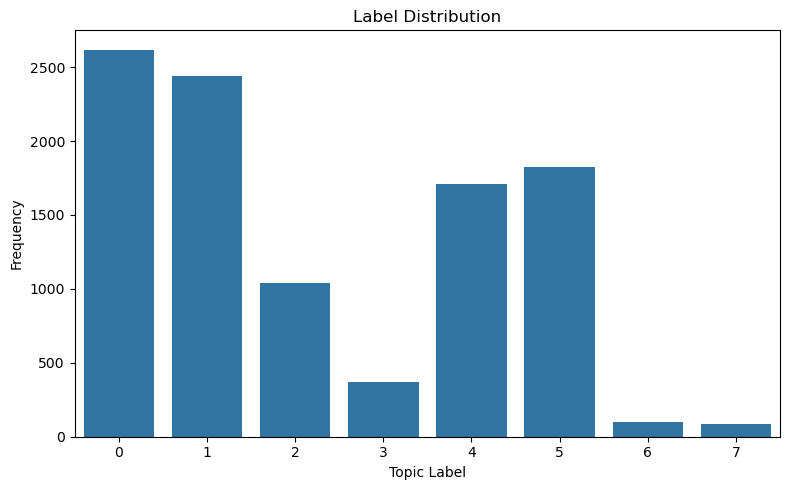

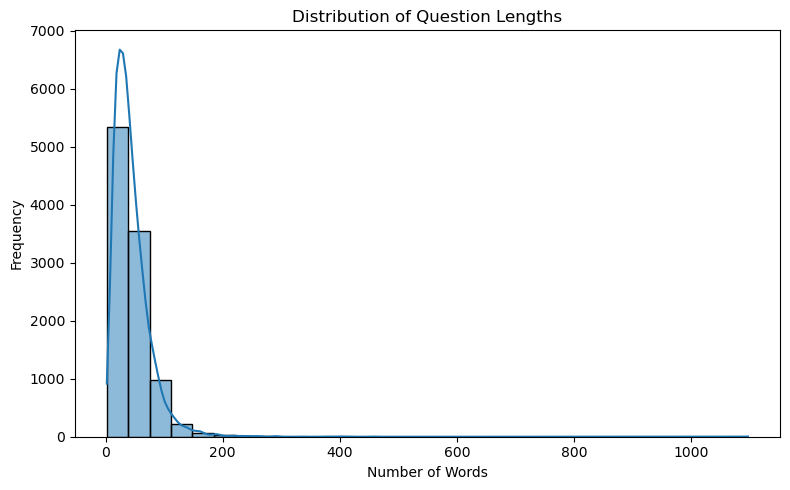

In [5]:
#Load dataset
df = pd.read_csv('C://Users/naifa/OneDrive/ML/Data/train.csv')  


# --- Dataset Info ---
print("Number of Samples:", len(df))
print("Number of Unique Labels:", df['label'].nunique())
print("Missing Values:\n", df.isnull().sum())
print("\nSample Entries:\n", df.head())

# --- Plot Label Distribution ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="label")
plt.title("Label Distribution")
plt.xlabel("Topic Label")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# --- Question Length Analysis ---
df["question_length"] = df["Question"].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(df["question_length"], bins=30, kde=True)
plt.title("Distribution of Question Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()





Top 10 tokens:
 [('number', 3361), ('find', 3286), ('numbers', 2334), ('let', 2005), ('positive', 1842), ('two', 1819), ('points', 1701), ('value', 1513), ('triangle', 1502), ('one', 1476)]


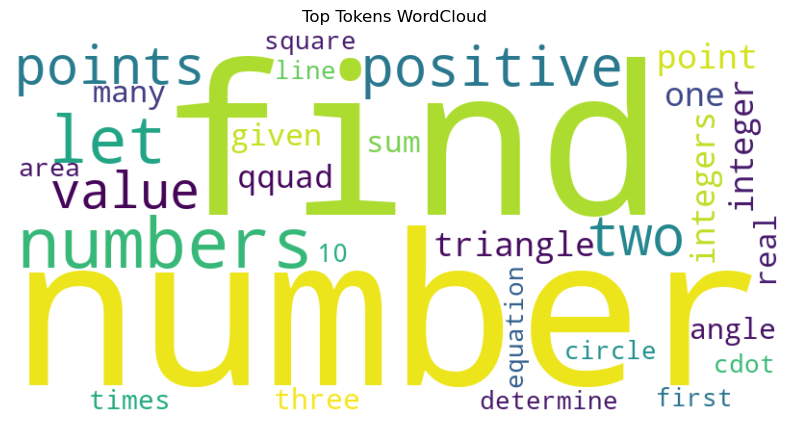

In [7]:
#add more features
# === Preprocess text ===
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english")) - {"find", "let", "given"}
    return [t for t in tokens if t not in stop_words and len(t) > 1]

df["tokens"] = df["Question"].apply(preprocess)
df["clean_text"] = df["tokens"].apply(lambda tokens: " ".join(tokens))

# === Handcrafted Numeric Features ===
df["question_length"] = df["clean_text"].apply(lambda x: len(x.split()))
df["char_length"] = df["clean_text"].apply(len)
df["num_digits"] = df["clean_text"].str.count(r"\d")
df["num_vars"] = df["clean_text"].str.count(r"\b[a-zA-Z]\b")
df["has_geometry_terms"] = df["clean_text"].str.contains(r"angle|circle|triangle", case=False).astype(int)
df["has_probability_terms"] = df["clean_text"].str.contains(r"probability|chance|likely", case=False).astype(int)
df["starts_with_find"] = df["clean_text"].str.startswith(("find", "determine", "calculate")).astype(int)
df["num_equals"] = df["clean_text"].str.count("=")

# === Class-Specific Keyword Features ===
def count_keywords(tokens, keywords):
    return sum(1 for token in tokens if token in keywords)

probability_keywords = {"probability that", "expected value"}#class3
linear_algebra_keywords = {"vector", "vectors", "times","equations", "matrix equation", "vector space"}#class6
abstract_algebra_keywords = {"prove", "element", "an element","prove that", "let be", "player"}#class7

df["probability_feature"] = df["tokens"].apply(lambda x: count_keywords(x, probability_keywords))
df["abstract_algebra_feature"] = df["tokens"].apply(lambda x: count_keywords(x, abstract_algebra_keywords))
df["linear_algebra_feature"] = df["tokens"].apply(lambda x: count_keywords(x, linear_algebra_keywords))

# === TF-IDF Vectorizer ===
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=10000,
    min_df=3,
    max_df=0.9
)
X_tfidf = vectorizer.fit_transform(df["clean_text"])

# === Scale and Combine Numeric Features ===
handcrafted_features = df[[
    "question_length", "char_length", "num_digits", "num_vars",
    "has_geometry_terms", "has_probability_terms",
    "starts_with_find", "num_equals"
]].values

scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(handcrafted_features)

# Combine sparse (X_tfidf) with dense numeric
X_combined = hstack([X_tfidf, numeric_scaled])

# Target labels
y = df["label"]

# === Top Tokens ===
all_tokens = [token for tokens in df["tokens"] for token in tokens]
top_tokens = Counter(all_tokens).most_common(30)
print("\nTop 10 tokens:\n", top_tokens[:10])

# === WordCloud ===
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(dict(top_tokens))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Top Tokens WordCloud")
plt.show()

In [60]:
def top_words_per_label(df, num_words=5):
   
    # Topic mapping for readability
    topic_map = {
        0: "Algebra",
        1: "Geometry and Trigonometry",
        2: "Calculus and Analysis",
        3: "Probability and Statistics",
        4: "Number Theory",
        5: "Combinatorics and Discrete Math",
        6: "Linear Algebra",
        7: "Abstract Algebra and Topology"
    }
    
    # Get top words for each label
    top_words = {}
    for label in range(8):
        # Filter tokens for this label
        label_tokens = [token for tokens in df[df['label'] == label]['tokens'] for token in tokens]
        # Count tokens
        word_counts = Counter(label_tokens)
        # Get top N words
        top_words[topic_map[label]] = word_counts.most_common(num_words)
    
    # Print results
    print("Top Words Per Label :")
    for topic, words in top_words.items():
        print(f"{topic}: {words}")

# Example usage (assuming df has 'tokens' column from your preprocessing)
top_words_per_label(df, num_words=10)

Top Words Per Label :
Algebra: [('real', 543), ('numbers', 528), ('number', 512), ('find', 505), ('let', 495), ('solve', 431), ('qquad', 387), ('value', 373), ('equation', 314), ('two', 279)]
Geometry and Trigonometry: [('triangle', 1410), ('point', 1121), ('angle', 1028), ('find', 988), ('points', 763), ('area', 757), ('circle', 656), ('line', 546), ('side', 542), ('let', 534)]
Calculus and Analysis: [('find', 494), ('value', 376), ('function', 317), ('real', 314), ('let', 287), ('numbers', 220), ('given', 203), ('positive', 187), ('sequence', 178), ('fx', 172)]
Probability and Statistics: [('probability', 349), ('number', 178), ('one', 162), ('two', 129), ('points', 126), ('find', 124), ('random', 102), ('numbers', 91), ('randomly', 88), ('first', 84)]
Number Theory: [('number', 1047), ('positive', 735), ('find', 690), ('integer', 673), ('numbers', 612), ('integers', 582), ('sum', 358), ('digits', 343), ('natural', 325), ('prime', 284)]
Combinatorics and Discrete Math: [('number', 12

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
   X_combined, y, stratify=y, test_size=0.2, random_state=42)
from imblearn.over_sampling import SMOTE

# After train_test_split
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



In [11]:
from sklearn.model_selection import StratifiedKFold

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [13]:
# === Logistic Regression untuned ===
#class_weight='balanced',
print("\n=== Logistic Regression (Untuned) ===")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print(f"Macro F1: {f1_score(y_test, lr_pred, average='macro'):.4f}")
print(f"Micro F1: {f1_score(y_test, lr_pred, average='micro'):.4f}")
print(classification_report(y_test, lr_pred))

lr_pred_untuned = lr_pred 

# === Logistic Regression tuned ===
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced'],
    'max_iter': [500, 1000]
}

lr_grid = GridSearchCV(
    estimator=LogisticRegression(class_weight='balanced', random_state=42),
    param_grid=lr_param_grid,
    scoring='f1_macro',
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1
)

lr_grid.fit(X_train, y_train)
best_lr = lr_grid.best_estimator_
lr_pred = best_lr.predict(X_test)

lr_acc = accuracy_score(y_test, lr_pred)
lr_macro = f1_score(y_test, lr_pred, average='macro')
lr_micro = f1_score(y_test, lr_pred, average='micro')

print("\n=== Logistic Regression (Tuned) ===")
print("Best Parameters:", lr_grid.best_params_)
print(f"Accuracy: {lr_acc:.4f}")
print(f"Macro F1: {lr_macro:.4f}")
print(f"Micro F1: {lr_micro:.4f}")
print(classification_report(y_test, lr_pred))


=== Logistic Regression (Untuned) ===
Accuracy: 0.7885
Macro F1: 0.6445
Micro F1: 0.7885
              precision    recall  f1-score   support

           0       0.71      0.86      0.78       524
           1       0.93      0.90      0.91       488
           2       0.74      0.64      0.69       208
           3       0.95      0.73      0.82        74
           4       0.76      0.78      0.77       342
           5       0.76      0.71      0.73       365
           6       1.00      0.05      0.10        20
           7       0.67      0.24      0.35        17

    accuracy                           0.79      2038
   macro avg       0.82      0.61      0.64      2038
weighted avg       0.80      0.79      0.78      2038

Fitting 5 folds for each of 16 candidates, totalling 80 fits

=== Logistic Regression (Tuned) ===
Best Parameters: {'C': 10, 'class_weight': 'balanced', 'max_iter': 500}
Accuracy: 0.7949
Macro F1: 0.7417
Micro F1: 0.7949
              precision    recall  f1-

In [14]:
# === Linear SVM (Untuned) ===
print("\n=== Linear SVM (Untuned) ===")
svm = LinearSVC(random_state=42)
svm.fit(X_train, y_train)
svm_pred_untuned = svm.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, svm_pred_untuned):.4f}")
print(f"Macro F1: {f1_score(y_test, svm_pred_untuned, average='macro'):.4f}")
print(f"Micro F1: {f1_score(y_test, svm_pred_untuned, average='micro'):.4f}")
print(classification_report(y_test, svm_pred_untuned))


# === Linear SVM (Tuned) ===
svm_param_grid = {
    'C': [0.01, 0.1, 1, 5, 10],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000, 2000]
}

svm_grid = GridSearchCV(
    estimator=LinearSVC(random_state=42),
    param_grid=svm_param_grid,
    scoring='f1_macro',
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_
svm_pred = best_svm.predict(X_test)

svm_acc = accuracy_score(y_test, svm_pred)
svm_macro = f1_score(y_test, svm_pred, average='macro')
svm_micro = f1_score(y_test, svm_pred, average='micro')

print("\n=== Linear SVM (Tuned) ===")
print("Best Parameters:", svm_grid.best_params_)
print(f"Accuracy: {svm_acc:.4f}")
print(f"Macro F1: {svm_macro:.4f}")
print(f"Micro F1: {svm_micro:.4f}")
print(classification_report(y_test, svm_pred))



=== Linear SVM (Untuned) ===
Accuracy: 0.8013
Macro F1: 0.7523
Micro F1: 0.8013
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       524
           1       0.93      0.91      0.92       488
           2       0.76      0.68      0.72       208
           3       0.92      0.81      0.86        74
           4       0.76      0.79      0.78       342
           5       0.79      0.73      0.75       365
           6       0.64      0.35      0.45        20
           7       0.92      0.65      0.76        17

    accuracy                           0.80      2038
   macro avg       0.81      0.72      0.75      2038
weighted avg       0.80      0.80      0.80      2038

Fitting 5 folds for each of 20 candidates, totalling 100 fits

=== Linear SVM (Tuned) ===
Best Parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 2000}
Accuracy: 0.8003
Macro F1: 0.7479
Micro F1: 0.8003
              precision    recall  f1-score   support



In [17]:
# === Random Forest (Untuned) ===
print("\n=== Random Forest (Untuned) ===")
rf = RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
rf_pred_untuned = rf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, rf_pred_untuned):.4f}")
print(f"Macro F1: {f1_score(y_test, rf_pred_untuned, average='macro'):.4f}")
print(f"Micro F1: {f1_score(y_test, rf_pred_untuned, average='micro'):.4f}")
print(classification_report(y_test, rf_pred_untuned))


# === Random Forest (Tuned) ===
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced',random_state=42),
    param_grid=rf_param_grid,
    scoring='f1_macro',
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1
)

rf_grid.fit(X_train_resampled, y_train_resampled)
best_rf = rf_grid.best_estimator_
rf_pred = best_rf.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
rf_macro = f1_score(y_test, rf_pred, average='macro')
rf_micro = f1_score(y_test, rf_pred, average='micro')

print("\n=== Random Forest (Tuned) ===")
print("Best Parameters:", rf_grid.best_params_)
print(f"Accuracy: {rf_acc:.4f}")
print(f"Macro F1: {rf_macro:.4f}")
print(f"Micro F1: {rf_micro:.4f}")
print(classification_report(y_test, rf_pred))



=== Random Forest (Untuned) ===
Accuracy: 0.7605
Macro F1: 0.7121
Micro F1: 0.7605
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       524
           1       0.89      0.88      0.89       488
           2       0.71      0.65      0.68       208
           3       0.92      0.78      0.85        74
           4       0.69      0.78      0.73       342
           5       0.73      0.66      0.69       365
           6       0.64      0.35      0.45        20
           7       0.69      0.65      0.67        17

    accuracy                           0.76      2038
   macro avg       0.75      0.69      0.71      2038
weighted avg       0.76      0.76      0.76      2038

Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== Random Forest (Tuned) ===
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.7659
Macro F1: 0.7213
Micro F1: 0.7659
              pr

In [30]:
# Predict using best trained models
pred_lr = best_lr.predict(X_test)
pred_svm = best_svm.predict(X_test)
pred_rf = best_rf.predict(X_test)

# Manual hard voting
from scipy.stats import mode
import numpy as np

voted_preds = np.vstack([pred_lr, pred_svm, pred_rf])
y_pred_ensemble = mode(voted_preds, axis=0, keepdims=False).mode

# Evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("\n=== Manual Voting Ensemble (Tuned Models) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ensemble):.4f}")
print(f"Macro F1: {f1_score(y_test, y_pred_ensemble, average='macro'):.4f}")
print(f"Micro F1: {f1_score(y_test, y_pred_ensemble, average='micro'):.4f}")
print(classification_report(y_test, y_pred_ensemble))



=== Manual Voting Ensemble (Tuned Models) ===
Accuracy: 0.8018
Macro F1: 0.7480
Micro F1: 0.8018
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       524
           1       0.94      0.91      0.92       488
           2       0.72      0.73      0.72       208
           3       0.91      0.85      0.88        74
           4       0.77      0.78      0.77       342
           5       0.79      0.73      0.76       365
           6       0.50      0.40      0.44        20
           7       0.71      0.71      0.71        17

    accuracy                           0.80      2038
   macro avg       0.76      0.74      0.75      2038
weighted avg       0.80      0.80      0.80      2038



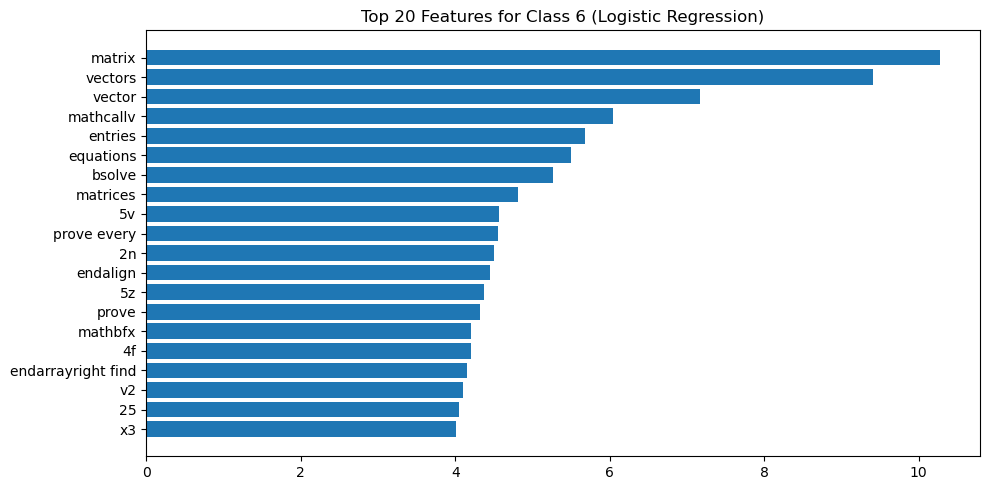

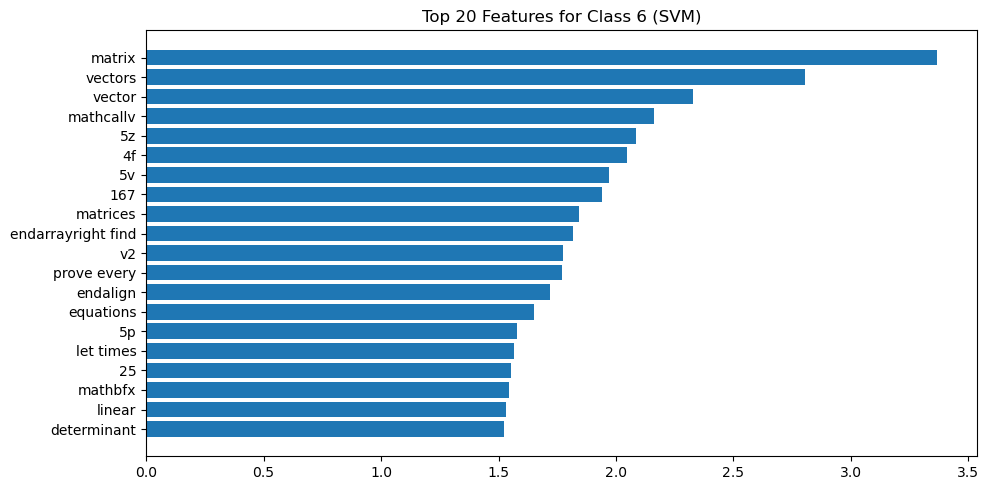

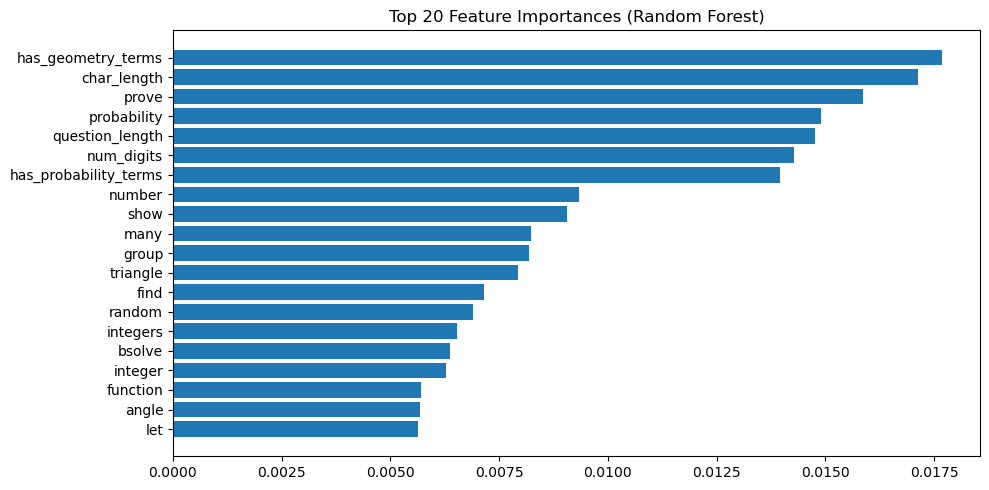

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Get combined feature names ===
tfidf_feature_names = vectorizer.get_feature_names_out()
numeric_feature_names = [
    "question_length", "char_length", "num_digits", "num_vars",
    "has_geometry_terms", "has_probability_terms",
    "starts_with_find", "num_equals",
    "abstract_algebra_feature", "linear_algebra_feature"
]
all_feature_names = list(tfidf_feature_names) + numeric_feature_names

# === Step 2: Logistic Regression Feature Importance ===
def plot_lr_features(model, class_idx=6, top_n=20):
    coefs = model.coef_[class_idx]
    top_idx = np.argsort(np.abs(coefs))[-top_n:]
    plt.figure(figsize=(10, 5))
    plt.barh(np.array(all_feature_names)[top_idx], coefs[top_idx])
    plt.title(f"Top {top_n} Features for Class {class_idx} (Logistic Regression)")
    plt.tight_layout()
    plt.show()

# === Step 3: SVM Feature Importance (same idea as LR) ===
def plot_svm_features(model, class_idx=6, top_n=20):
    coefs = model.coef_[class_idx]
    top_idx = np.argsort(np.abs(coefs))[-top_n:]
    plt.figure(figsize=(10, 5))
    plt.barh(np.array(all_feature_names)[top_idx], coefs[top_idx])
    plt.title(f"Top {top_n} Features for Class {class_idx} (SVM)")
    plt.tight_layout()
    plt.show()

# === Step 4: Random Forest Feature Importance ===
def plot_rf_features(model, top_n=20):
    importances = model.feature_importances_
    top_idx = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(10, 5))
    plt.barh(np.array(all_feature_names)[top_idx], importances[top_idx])
    plt.title(f"Top {top_n} Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.show()

# === Usage Example (for class 0 in LR and SVM) ===
plot_lr_features(best_lr, class_idx=6)
plot_svm_features(best_svm, class_idx=6)
plot_rf_features(best_rf)


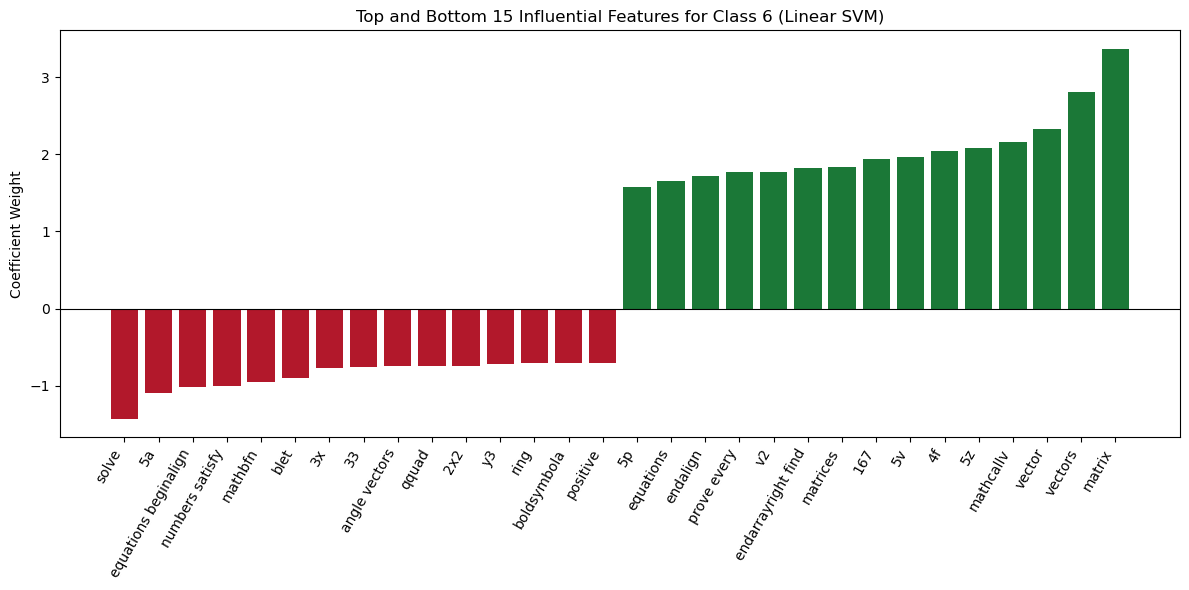

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === Step 1: Extract coefficients for Class 6 ===
class_index = 6  # Linear Algebra
coefs = best_svm.coef_[class_index]
feature_names = vectorizer.get_feature_names_out()
top_n = 15

# === Step 2: Get top and bottom n feature indices ===
top_pos_idx = np.argsort(coefs)[-top_n:]
top_neg_idx = np.argsort(coefs)[:top_n]
top_idx = np.concatenate([top_neg_idx, top_pos_idx])

# === Step 3: Prepare plotting data ===
terms = np.array(feature_names)[top_idx]
weights = coefs[top_idx]
colors = ['#b2182b' if w < 0 else '#1b7837' for w in weights]  # red = negative, green = positive

df_plot = pd.DataFrame({'term': terms, 'weight': weights, 'color': colors})

# === Step 4: Plot ===
plt.figure(figsize=(12, 6))
plt.bar(df_plot['term'], df_plot['weight'], color=df_plot['color'])
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=60, ha='right')
plt.ylabel('Coefficient Weight')
plt.title('Top and Bottom 15 Influential Features for Class 6 (Linear SVM)')
plt.tight_layout()
plt.show()


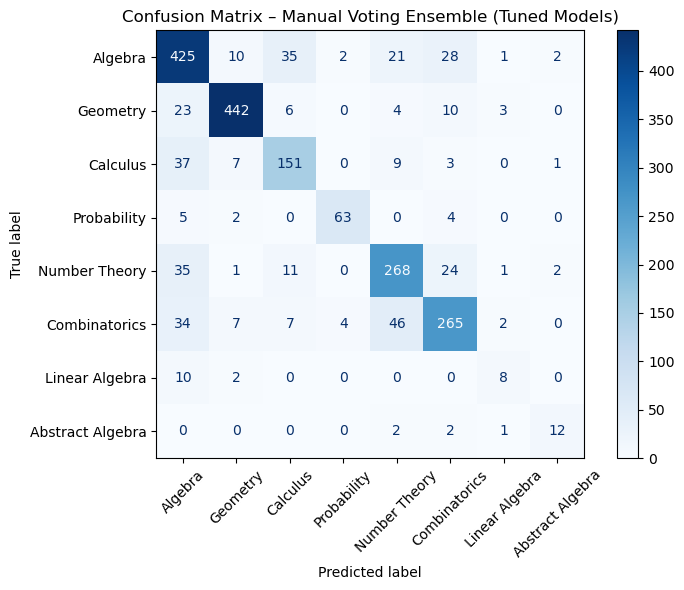

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# === Optional: Replace with your real topic names ===
class_labels = [
    "Algebra",              # Class 0
    "Geometry",             # Class 1
    "Calculus",             # Class 2
    "Probability",          # Class 3
    "Number Theory",        # Class 4
    "Combinatorics",        # Class 5
    "Linear Algebra",       # Class 6
    "Abstract Algebra"      # Class 7
]

# === Generate confusion matrix ===
cm = confusion_matrix(y_test, y_pred_ensemble)

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix – Manual Voting Ensemble (Tuned Models)")
plt.tight_layout()
plt.show()
